## Проект по биоинформатике протеиновых последовательностей! 
### Использование **базовых фич** аминокислот в последовательностях **белков** для классификации их классов и сравнение качества с моделями, основанными на наученных **эмбеддингах**

# Обзор ресурсов

[пеперы про ML в белках](https://github.com/yangkky/Machine-learning-for-proteins#classification-and-annotation)

- [ProtLearn](https://github.com/tadorfer/ProtLearn) - либа базовых фичь и индексов. **Используем ее для генерации признаков для классификации**
- [embedding - есть модель, но непонятно](https://github.com/tbepler/protein-sequence-embedding-iclr2019)
- [tape embedding](https://github.com/songlab-cal/tape) -  - что-то шикарное, берт на белках. Удобная либа - **работает**. Используем эмбеддинги для сравнения
- [bio_embeddings](https://github.com/sacdallago/bio_embeddings)  - тоже что-то хорошее с интерфейсом.  **не устанавливается в колаб**
- [подход с LSTM, точнее они придумали лучшее решение на CNN](https://github.com/ronakvijay/Protein_Sequence_Classification)
- []()
- [shap](https://github.com/slundberg/shap) - оценщик бустинга. **оцениваем им значимость индексов для классов белков**

Однако, если мы берем эмбеддинги, а не фичи, то бустинг нельзя оценить. Эмбеддинги просто для сравнения 

Запускаем тетрадку в колабе и сливаем датасет прямо с каггла

In [0]:
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/ # this file can be obtained from kaggle account (token)
!chmod 600 /root/.kaggle/kaggle.json # no one must see this file

In [0]:
!kaggle datasets download -d shahir/protein-data-set
!unzip protein-data-set.zip

 80% 22.0M/27.4M [00:00<00:00, 24.5MB/s]
100% 27.4M/27.4M [00:00<00:00, 46.8MB/s]
Archive:  protein-data-set.zip
  inflating: pdb_data_no_dups.csv    
  inflating: pdb_data_seq.csv        


In [0]:
!pip install protlearn shap catboost

# Classification on aa index features

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('pdb_data_seq.csv')
df_char = pd.read_csv('pdb_data_no_dups.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Collect data

In [2]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [4]:
# Join two datasets on structureId
data = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
data.columns = ['classification', 'Sequence']
data.head()

,classification,Sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
# Check NA counts
data.isnull().sum()

classification    1
Sequence          3
dtype: int64

In [6]:
# Drop rows with missing values
data = data.dropna()
print('%d is the number of proteins that have a classification and sequence' %data.shape[0])

346321 is the number of proteins that have a classification and sequence


In [7]:
# filter seqs containing non-canonical aa 
aa_list = set('A 	C 	D 	E 	F 	G 	H 	I 	K 	L 	M 	N 	P 	Q 	R 	S 	T 	V 	W 	Y'.split())
_mask = data.Sequence.apply(lambda s: len(set.difference(set(s), aa_list)) == 0)
data = data[_mask]
data.shape

(338416, 2)

In [8]:
len(set(data.classification)), 'classes'

(4401, 'classes')

In [9]:
# some classes are dublicated by lowercase
new_classification = data.classification.str.upper()
data['classification'] = new_classification
len(set(new_classification)), 'new classes'

(3525, 'new classes')

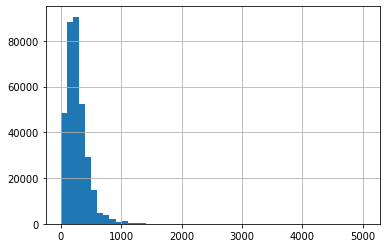

In [10]:
# look at seq_len distribution
data.Sequence.str.len().hist(bins=50)

In [11]:
# delete long seqs to decrease computations time | not need
data = data[data.Sequence.str.len() <= 1000]
data.shape

(335726, 2)

In [12]:
# there are too many seqs. Computing of features require >20 hours. Decrease dataset
_, _X_data, _, _y_data = train_test_split(data.Sequence, data['classification'], test_size = 0.25, random_state = 1128)
data = pd.DataFrame({'Sequence':_X_data, 'classification':_y_data})
data.shape

(83932, 2)

HYDROLASE                        11250
TRANSFERASE                       8965
OXIDOREDUCTASE                    8394
IMMUNE SYSTEM                     3851
HYDROLASE/HYDROLASE INHIBITOR     3114
LYASE                             2879
TRANSCRIPTION                     2172
VIRAL PROTEIN                     2113
TRANSPORT PROTEIN                 2006
VIRUS                             1666
Name: classification, dtype: int64


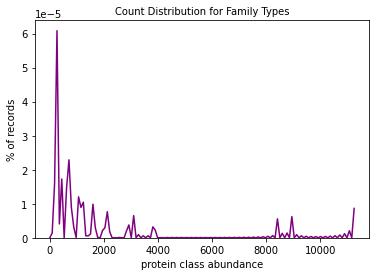

In [13]:
# Look at classification type counts
counts = data.classification.value_counts()
print(counts[:10])

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types', fontsize=10)
plt.ylabel('% of records')
plt.xlabel('protein class abundance')
plt.show()

## Выбор семейств для классификации
Распределение не самое красивое. Лэйблы датасета включают в себя не только ферментативную функциональность, но и локализацию, участие в макропроцессе, какие-то уточнения или непонятки. Всего намешали, но возьмем только часть

In [0]:
# это самые частые классы, но их много
used_classes= ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM',
            'HYDROLASE/HYDROLASE INHIBITOR', 'LYASE', 'TRANSCRIPTION',
            'VIRAL PROTEIN', 'TRANSPORT PROTEIN', 'VIRUS', 'SIGNALING PROTEIN',
            'ISOMERASE', 'LIGASE', 'MEMBRANE PROTEIN', 'PROTEIN BINDING',
            'TRANSFERASE/TRANSFERASE INHIBITOR', 'STRUCTURAL PROTEIN',
            'CHAPERONE', 'SUGAR BINDING PROTEIN', 'DNA BINDING PROTEIN',
            'PHOTOSYNTHESIS', 'ELECTRON TRANSPORT', 'METAL BINDING PROTEIN',
            'CELL ADHESION', 'PROTEIN TRANSPORT', 'TOXIN', 'CELL CYCLE',
            'RNA BINDING PROTEIN', 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR',
            'VIRAL PROTEIN/IMMUNE SYSTEM', 'HORMONE', 'GENE REGULATION',
            'APOPTOSIS', 'MOTOR PROTEIN', 'PROTEIN FIBRIL', 'METAL TRANSPORT',
            'CONTRACTILE PROTEIN', 'TRANSCRIPTION REGULATOR', 'FLUORESCENT PROTEIN', 
            'TRANSLATION', 'BIOSYNTHETIC PROTEIN', 'OXYGEN TRANSPORT', 
            'LIPID BINDING PROTEIN', 'CYTOKINE']

# возьмем только канонические классы и интересные
used_classes = ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'LYASE', 'ISOMERASE', 
                'LIGASE', 'FLUORESCENT PROTEIN', 'BIOSYNTHETIC PROTEIN','VIRUS', 
                'SUGAR BINDING PROTEIN','HORMONE','TRANSCRIPTION', 'MEMBRANE PROTEIN']

In [15]:
counts[used_classes]

HYDROLASE                11250
TRANSFERASE               8965
OXIDOREDUCTASE            8394
LYASE                     2879
ISOMERASE                 1549
LIGASE                    1170
FLUORESCENT PROTEIN        255
BIOSYNTHETIC PROTEIN       259
VIRUS                     1666
SUGAR BINDING PROTEIN      852
HORMONE                    367
TRANSCRIPTION             2172
MEMBRANE PROTEIN          1181
Name: classification, dtype: int64

## Compute features



In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
from protlearn import length, composition, aaindex1, aaindex2, aaindex3, ngram_composition
df = data[['Sequence']]
df.shape

(83932, 1)

In [0]:
%time aaind1 = aaindex1(df, standardize='none') # 14 min
aaind1.index = df.index
aaind1.columns = list(map(lambda x: 'ind1_' + x, aaind1.columns))
aaind1.to_csv('/gdrive/My Drive/aaind1.csv')

CPU times: user 14min 17s, sys: 3.43 s, total: 14min 20s
Wall time: 14min 23s


In [0]:
# %time comp = composition(df, method='relative') # 50 sec

%time aaind1 = aaindex1(df, standardize='none') # 24 min | 12 min
aaind1.index = df.index
aaind1.columns = list(map(lambda x: 'ind1_' + x, aaind1.columns))
aaind1.to_csv('/gdrive/My Drive/aaind1_full.csv')
print(1)

%time aaind2 = aaindex2(df, standardize='none') # >8h | >3h
aaind2.index = df.index
aaind2.columns = list(map(lambda x: 'ind2_' + x, aaind2.columns))
aaind2.to_csv('/gdrive/My Drive/aaind2_full.csv')
print(2)

%time aaind3 = aaindex3(df, standardize='none') # >8h | >3h
aaind3.index = df.index
aaind3.columns = list(map(lambda x: 'ind3_' + x, aaind3.columns))
aaind3.to_csv('/gdrive/My Drive/aaind3_full.csv')

# bigram = ngram_composition(df, 2) # 40 min
# trigram = ngram_composition(df, 3) # 1.5 h

### Load stored data

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
# load previously saved index data
aaind1 = pd.read_csv('/gdrive/My Drive/aaind1.csv', index_col=0)
aaind2 = pd.read_csv('/gdrive/My Drive/aaind2.csv', index_col=0)
aaind3 = pd.read_csv('/gdrive/My Drive/aaind3.csv', index_col=0)

In [0]:
aaind3.head()

,ind3_TANS760101,ind3_TANS760102,ind3_BRYS930101,ind3_THOP960101,ind3_MIRL960101,ind3_VENM980101,ind3_BASU010101,ind3_MIYS850102,ind3_MIYS850103,ind3_MIYS960101,ind3_MIYS960102,ind3_MIYS960103,ind3_MIYS990106,ind3_MIYS990107,ind3_LIWA970101,ind3_KESO980101,ind3_KESO980102,ind3_MOOG990101,ind3_BETM990101,ind3_TOBD000101,ind3_TOBD000102,ind3_KOLA930101,ind3_SKOJ970101,ind3_SKOJ000101,ind3_SKOJ000102,ind3_BONM030101,ind3_BONM030102,ind3_BONM030103,ind3_BONM030104,ind3_BONM030105,ind3_BONM030106,ind3_MICC010101,ind3_SIMK990101,ind3_SIMK990102,ind3_SIMK990103,ind3_SIMK990104,ind3_SIMK990105,ind3_ZHAC000101,ind3_ZHAC000104,ind3_ZHAC000106,ind3_ZHAC000102,ind3_ZHAC000103,ind3_ZHAC000105
structureId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5JQC,-4.388760,63.996124,0.024667,-0.091667,0.014457,-0.002947,0.004094,-2.403566,0.025194,-2.726977,0.033992,6875.027132,0.013876,0.024225,-2.934845,-3.051240,0.002442,-0.096008,0.012868,0.070426,0.138023,0.074806,0.306977,0.255814,0.119767,0.339922,0.244186,-0.230620,5.460853,5.597287,5.634496,0.007386,0.045866,0.016155,0.003019,-0.001607,0.000568,-0.642364,-1.532442,0.422752,0.152519,0.444109,0.101357
1Z0M,-4.513684,58.631579,0.002084,-0.066947,0.021053,-0.004853,0.008306,-2.613368,0.016000,-2.921158,0.040526,6583.157895,-0.001684,0.026737,-3.010316,-3.207684,0.004842,-0.073053,0.013789,0.057684,0.065684,0.062105,0.207368,0.177895,0.038947,0.235789,0.146316,-0.274737,5.422105,5.642105,5.698947,-0.000233,0.005506,0.009333,-0.001173,0.003232,0.000128,-0.594421,-1.491053,0.403895,0.172737,0.436105,0.105895
4NM8,-4.288584,60.442922,-0.000073,-0.087991,0.015388,-0.003149,0.001435,-2.445023,0.012648,-2.780639,0.015068,7089.146119,0.001918,0.013014,-2.983516,-3.173333,-0.009361,-0.084977,0.012192,0.015068,0.054703,0.019178,0.269406,0.218721,0.072146,0.252055,0.161187,-0.295434,5.397717,5.573516,5.633790,0.000022,0.006516,-0.000551,-0.006191,-0.000930,-0.000040,-0.620457,-1.531918,0.400959,0.123927,0.385799,0.085023
1O6L,-4.679464,62.937500,-0.003030,-0.122173,0.003393,-0.004866,-0.034465,-2.865655,0.005149,-3.213571,0.015268,7373.014881,-0.056875,0.012202,-3.134226,-3.569881,-0.013155,-0.025952,-0.052589,-0.033988,-0.022560,-0.020238,0.122917,0.090774,-0.038690,0.219048,0.104464,-0.343155,5.528869,5.680952,5.730357,0.000501,0.014697,0.003595,-0.008962,-0.003460,-0.000618,-0.685417,-1.643542,0.338512,0.003720,0.302500,0.035357
2B7L,-4.733588,61.824427,0.037183,-0.048855,0.073664,0.003826,-0.026889,-2.691908,0.068015,-3.024351,0.070840,6658.534351,0.002595,0.043893,-3.012519,-3.496870,-0.006947,-0.022901,0.010000,0.019160,-0.005649,0.096947,0.197710,0.115267,-0.032061,0.333588,0.171756,-0.316794,5.518321,5.751908,5.803053,0.000183,0.069590,0.029382,0.003531,-0.002943,0.000239,-0.550534,-1.518779,0.437634,0.238855,0.433664,0.149389


## Train models and evaluate!
### Продвинутый бустинг делать не будем. Обойдемся минимальной настройкой. Есть мнение, что если фича значима, то оценить ее значение классификатору будет легко и так

In [0]:
aaind1.shape,aaind2.shape,aaind3.shape

((83932, 553), (83932, 92), (83932, 43))

In [0]:
# merge all index data to one features set
X = pd.concat([aaind1, aaind2, aaind3], axis=1)
# X = aaind1
# y = data['classification'] == 'TRANSFERASE'
# y = y.astype(int)
X.shape, y.shape

((83932, 688), (83932,))

In [0]:
# Отскалим. Хотя, как оказалось, это бесполезно
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X = X_scaled

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score
from catboost import CatBoostClassifier

def train(X):
    ''' 
    Функция для обучения. По данному набору признаков строит модельки и возвращает их
    '''
    classifiers = []

    for current_class in used_classes:
        print(current_class)
        y = (data['classification'] == current_class).astype(int)
        print('class proportion={:.2f}'.format(y.sum() / len(y)))
        
        X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 1128)
        model = CatBoostClassifier(iterations=300,
                                    depth=6,
                                    learning_rate=1,
                                    loss_function='CrossEntropy',
                                    verbose=True, 
                                    eval_metric='Recall')
        # train the model
        model.fit(X_train, y_train, eval_set=(X_test, y_test), 
                  metric_period=50, early_stopping_rounds=50)
        
        # make the prediction using the resulting model
        preds = model.predict(X_test)

        score = roc_auc_score(y_test, preds)
        classifiers.append((current_class, model, score))
        print('score =', round(score, 3))
        print('-'*20)
        print()
    return classifiers

In [0]:
classifiers = train(X)

HYDROLASE
class proportion=0.13


0:	learn: 0.0010708	test: 0.0007030	best: 0.0007030 (0)	total: 385ms	remaining: 1m 55s
50:	learn: 0.5634741	test: 0.4576450	best: 0.4579965 (49)	total: 19.5s	remaining: 1m 35s
100:	learn: 0.7412255	test: 0.5750439	best: 0.5750439 (100)	total: 38.8s	remaining: 1m 16s
150:	learn: 0.8212968	test: 0.6312830	best: 0.6312830 (150)	total: 58s	remaining: 57.2s
200:	learn: 0.8775729	test: 0.6576450	best: 0.6583480 (199)	total: 1m 18s	remaining: 38.7s
250:	learn: 0.9112433	test: 0.6724077	best: 0.6724077 (250)	total: 1m 39s	remaining: 19.4s
299:	learn: 0.9284949	test: 0.6840070	best: 0.6857645 (279)	total: 1m 58s	remaining: 0us

bestTest = 0.6857644991
bestIteration = 279

Shrink model to first 280 iterations.
score = 0.827
--------------------

TRANSFERASE
class proportion=0.11


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 418ms	remaining: 2m 5s
50:	learn: 0.5949926	test: 0.4786207	best: 0.4786207 (50)	total: 20.1s	remaining: 1m 37s
100:	learn: 0.7755523	test: 0.6059770	best: 0.6059770 (100)	total: 39.6s	remaining: 1m 18s
150:	learn: 0.8702504	test: 0.6611494	best: 0.6611494 (148)	total: 59.3s	remaining: 58.5s
200:	learn: 0.9253314	test: 0.6947126	best: 0.6947126 (200)	total: 1m 19s	remaining: 38.9s
250:	learn: 0.9546392	test: 0.7227586	best: 0.7227586 (249)	total: 1m 39s	remaining: 19.3s
299:	learn: 0.9630339	test: 0.7218391	best: 0.7273563 (287)	total: 1m 58s	remaining: 0us

bestTest = 0.7273563218
bestIteration = 287

Shrink model to first 288 iterations.
score = 0.852
--------------------

OXIDOREDUCTASE
class proportion=0.10


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 356ms	remaining: 1m 46s
50:	learn: 0.7295934	test: 0.6088867	best: 0.6088867 (50)	total: 19.8s	remaining: 1m 36s
100:	learn: 0.8725181	test: 0.7070313	best: 0.7109375 (98)	total: 39.5s	remaining: 1m 17s
150:	learn: 0.9423259	test: 0.7578125	best: 0.7578125 (148)	total: 59.3s	remaining: 58.5s
200:	learn: 0.9733691	test: 0.7729492	best: 0.7729492 (200)	total: 1m 18s	remaining: 38.9s
250:	learn: 0.9787268	test: 0.7792969	best: 0.7792969 (250)	total: 1m 38s	remaining: 19.2s
299:	learn: 0.9804601	test: 0.7832031	best: 0.7856445 (284)	total: 1m 57s	remaining: 0us

bestTest = 0.7856445313
bestIteration = 284

Shrink model to first 285 iterations.
score = 0.885
--------------------

LYASE
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 380ms	remaining: 1m 53s
50:	learn: 0.7474466	test: 0.5613793	best: 0.5710345 (48)	total: 20.6s	remaining: 1m 40s
100:	learn: 0.9187558	test: 0.6896552	best: 0.6951724 (98)	total: 41.3s	remaining: 1m 21s
150:	learn: 0.9786444	test: 0.7241379	best: 0.7351724 (144)	total: 1m	remaining: 60s
200:	learn: 0.9809656	test: 0.7310345	best: 0.7420690 (184)	total: 1m 20s	remaining: 39.5s
250:	learn: 0.9856082	test: 0.7255172	best: 0.7434483 (204)	total: 1m 39s	remaining: 19.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7434482759
bestIteration = 204

Shrink model to first 205 iterations.
score = 0.87
--------------------

ISOMERASE
class proportion=0.02


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 380ms	remaining: 1m 53s
50:	learn: 0.7521968	test: 0.5279805	best: 0.5304136 (49)	total: 19.2s	remaining: 1m 33s
100:	learn: 0.9411248	test: 0.6447689	best: 0.6520681 (95)	total: 38.4s	remaining: 1m 15s
150:	learn: 0.9701230	test: 0.6545012	best: 0.6642336 (113)	total: 57.6s	remaining: 56.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6642335766
bestIteration = 113

Shrink model to first 114 iterations.
score = 0.831
--------------------

LIGASE
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 367ms	remaining: 1m 49s
50:	learn: 0.7062147	test: 0.3824561	best: 0.3824561 (50)	total: 19.3s	remaining: 1m 34s
100:	learn: 0.9423729	test: 0.5543860	best: 0.5543860 (95)	total: 38.6s	remaining: 1m 16s
150:	learn: 0.9581921	test: 0.5754386	best: 0.5754386 (147)	total: 57.6s	remaining: 56.8s
200:	learn: 0.9559322	test: 0.5614035	best: 0.5789474 (175)	total: 1m 16s	remaining: 37.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5789473684
bestIteration = 175

Shrink model to first 176 iterations.
score = 0.788
--------------------

FLUORESCENT PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 371ms	remaining: 1m 50s
50:	learn: 1.0000000	test: 0.7868852	best: 0.7868852 (17)	total: 18.3s	remaining: 1m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7868852459
bestIteration = 17

Shrink model to first 18 iterations.
score = 0.893
--------------------

BIOSYNTHETIC PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 369ms	remaining: 1m 50s
50:	learn: 0.8950000	test: 0.5932203	best: 0.6101695 (40)	total: 18.6s	remaining: 1m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6101694915
bestIteration = 40

Shrink model to first 41 iterations.
score = 0.805
--------------------

VIRUS
class proportion=0.02


0:	learn: 0.3698083	test: 0.3888889	best: 0.3888889 (0)	total: 589ms	remaining: 2m 56s
50:	learn: 0.9848243	test: 0.8816425	best: 0.8864734 (46)	total: 19.9s	remaining: 1m 37s
100:	learn: 0.9896166	test: 0.8864734	best: 0.8913043 (59)	total: 37.9s	remaining: 1m 14s
150:	learn: 0.9904153	test: 0.8864734	best: 0.8937198 (103)	total: 54.9s	remaining: 54.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8937198068
bestIteration = 103

Shrink model to first 104 iterations.
score = 0.946
--------------------

SUGAR BINDING PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 375ms	remaining: 1m 52s
50:	learn: 0.9041534	test: 0.7256637	best: 0.7345133 (44)	total: 18.2s	remaining: 1m 29s
100:	learn: 0.9648562	test: 0.7787611	best: 0.7787611 (77)	total: 36.5s	remaining: 1m 11s
150:	learn: 0.9792332	test: 0.7831858	best: 0.7831858 (101)	total: 54.6s	remaining: 53.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7831858407
bestIteration = 101

Shrink model to first 102 iterations.
score = 0.891
--------------------

HORMONE
class proportion=0.00


0:	learn: 0.6309963	test: 0.7604167	best: 0.7604167 (0)	total: 377ms	remaining: 1m 52s
50:	learn: 0.9594096	test: 0.8229167	best: 0.8229167 (7)	total: 17.2s	remaining: 1m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8229166667
bestIteration = 7

Shrink model to first 8 iterations.
score = 0.911
--------------------

TRANSCRIPTION
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 358ms	remaining: 1m 46s
50:	learn: 0.6423718	test: 0.4141049	best: 0.4231465 (48)	total: 18.1s	remaining: 1m 28s
100:	learn: 0.8486720	test: 0.5226040	best: 0.5262206 (95)	total: 35.9s	remaining: 1m 10s
150:	learn: 0.9190859	test: 0.5443038	best: 0.5533454 (148)	total: 54s	remaining: 53.3s
200:	learn: 0.9363805	test: 0.5497288	best: 0.5551537 (163)	total: 1m 12s	remaining: 35.5s
250:	learn: 0.9369981	test: 0.5587703	best: 0.5605787 (212)	total: 1m 29s	remaining: 17.5s
299:	learn: 0.9351452	test: 0.5587703	best: 0.5623870 (260)	total: 1m 46s	remaining: 0us

bestTest = 0.5623869801
bestIteration = 260

Shrink model to first 261 iterations.
score = 0.779
--------------------

MEMBRANE PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 370ms	remaining: 1m 50s
50:	learn: 0.7273756	test: 0.5454545	best: 0.5454545 (50)	total: 18s	remaining: 1m 27s
100:	learn: 0.8902715	test: 0.6060606	best: 0.6094276 (92)	total: 35.9s	remaining: 1m 10s
150:	learn: 0.9298643	test: 0.6195286	best: 0.6262626 (148)	total: 56s	remaining: 55.2s
200:	learn: 0.9309955	test: 0.6195286	best: 0.6296296 (153)	total: 1m 14s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6296296296
bestIteration = 153

Shrink model to first 154 iterations.
score = 0.814
--------------------



In [0]:
# how good are our classifiers?
for cclass,_,score in sorted(classifiers, key=lambda x:x[-1]):
    print(cclass + ' '*(20-len(cclass)) + '\t', round(score, 3))

#cclass               score

TRANSCRIPTION       	 0.779
LIGASE              	 0.788
BIOSYNTHETIC PROTEIN	 0.805
MEMBRANE PROTEIN    	 0.814
HYDROLASE           	 0.827
ISOMERASE           	 0.831
TRANSFERASE         	 0.852
LYASE               	 0.87
OXIDOREDUCTASE      	 0.885
SUGAR BINDING PROTEIN	 0.891
FLUORESCENT PROTEIN 	 0.893
HORMONE             	 0.911
VIRUS               	 0.946


Это хороший результат, потому что эти фичи являются усреднением индексов для каждой аминокислоты в последовательности. Т.е. классификаторы несут не так много структурной информации, как могли бы.

Чуть-чуть интерпретации:
- за **транскрипцию** отвечают разные белки с разными функциями, поэтому классификация без учета структуры плохая
- **мембранные белки** по идее должны быть гидрофобны и так далее и их легко узнать, но нет, скор низкий. Видимо и здесь не хватает структурной информации
- **вирусы** не знаю почему так хорошо предсказываются
- **гидролазы** и **лигазы** бывают сильно разными, видимо

Тут будут хорошо работать свертки, которые будут учитывать домены белков и их взаимодействие.

Кроме того, если использовать весь сет белков, то качество значительно возрастает

## Estimate feature values

In [0]:
# visualizate shap_values and collect most valuable features for each class
import shap

def visualization(classifiers, X):
    shap.initjs()

    valuable_faetures = []
    for cclass,model,score in classifiers:
        print(cclass)
        cprop = (data['classification'] == cclass).sum() / len(data)
        print(f'class proportion={round(cprop, 2)}; score={round(score, 2)}')

        # explain the model's predictions using SHAP
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        shap.summary_plot(shap_values, X, max_display=10)
        shap.summary_plot(shap_values, X, max_display=10, plot_type='bar')

        # compute and store best features
        vals= np.abs(shap_values).mean(0)
        feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        best_features = feature_importance.head(10)
        valuable_faetures.append((cclass, best_features))
        print('-'*20)

    return valuable_faetures

HYDROLASE
class proportion=0.13; score=0.83


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


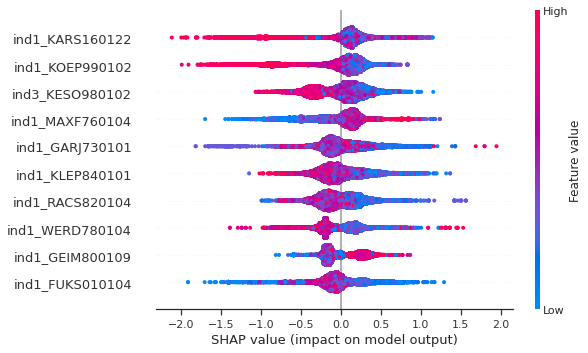

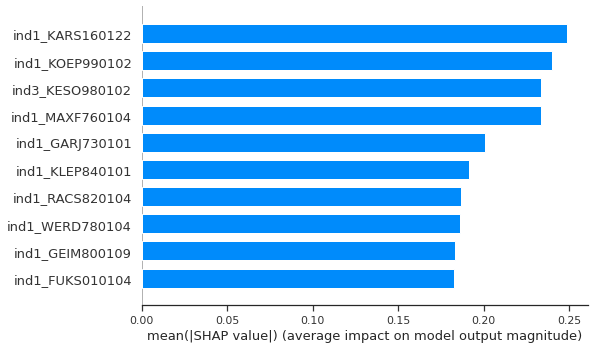

--------------------
TRANSFERASE
class proportion=0.11; score=0.85


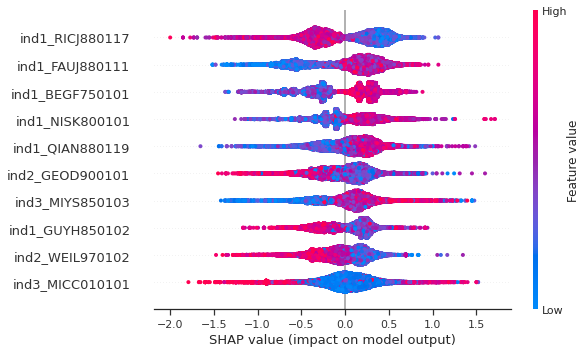

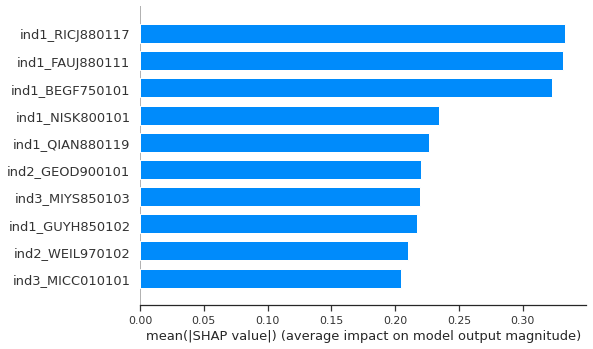

--------------------
OXIDOREDUCTASE
class proportion=0.1; score=0.89


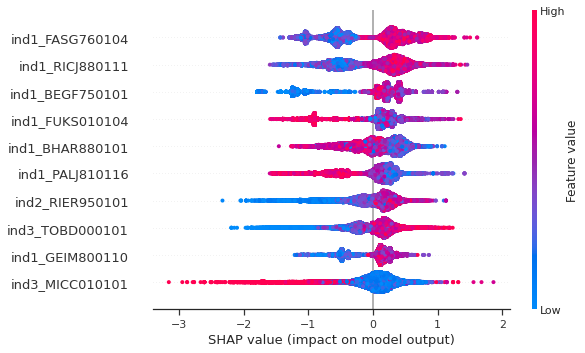

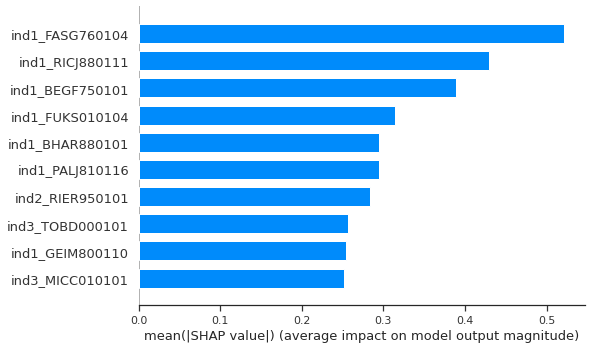

--------------------
LYASE
class proportion=0.03; score=0.87


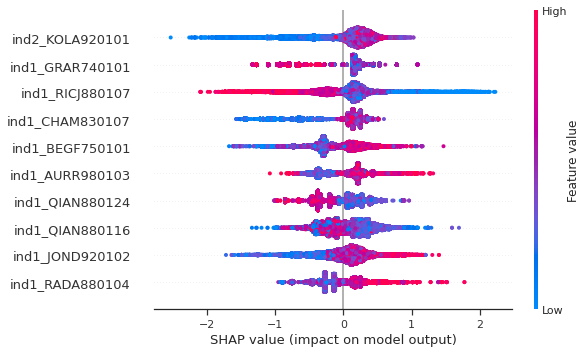

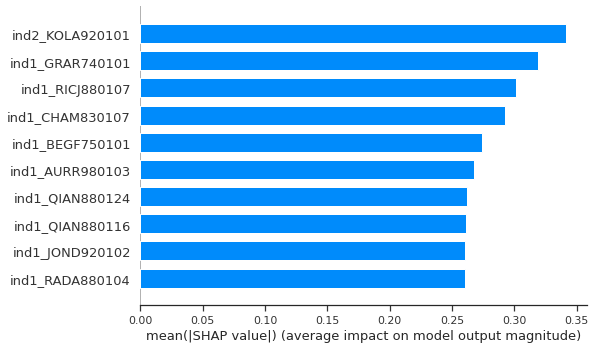

--------------------
ISOMERASE
class proportion=0.02; score=0.83


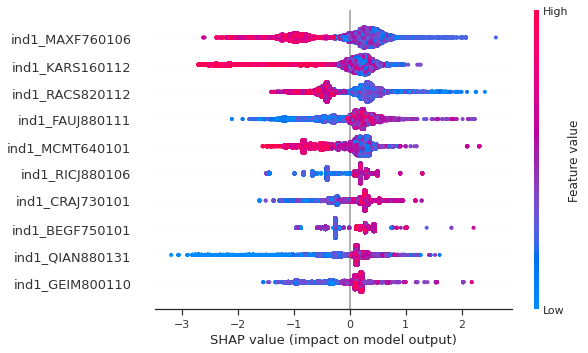

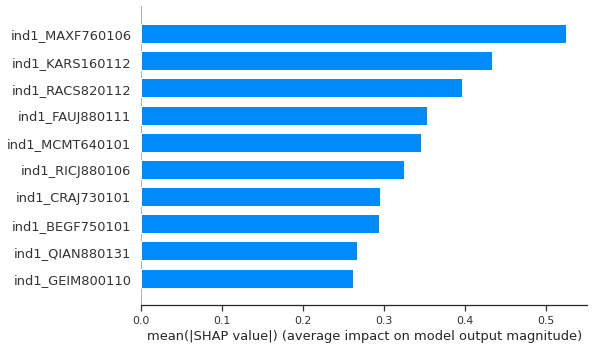

--------------------
LIGASE
class proportion=0.01; score=0.79


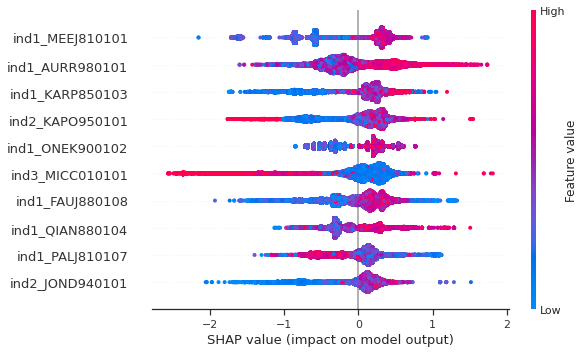

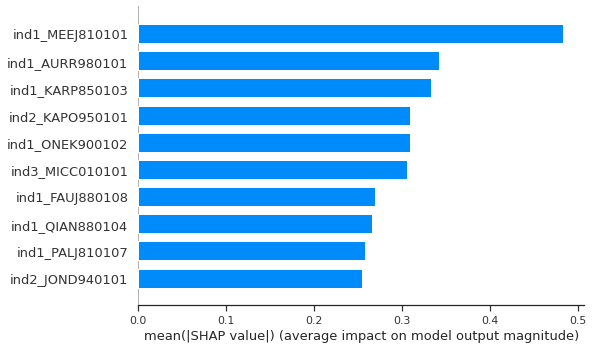

--------------------
FLUORESCENT PROTEIN
class proportion=0.0; score=0.89


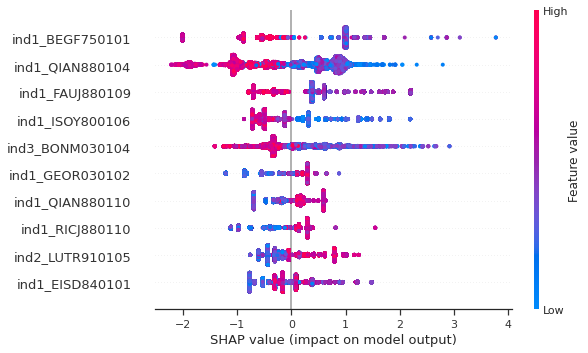

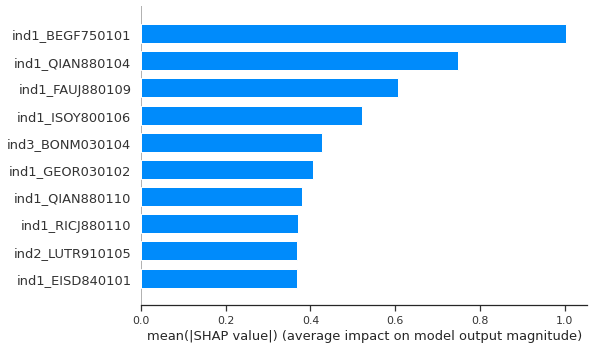

--------------------
BIOSYNTHETIC PROTEIN
class proportion=0.0; score=0.81


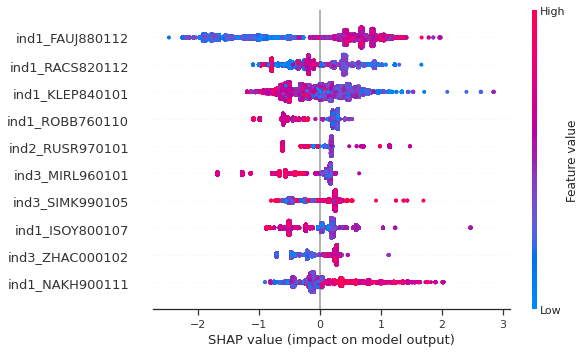

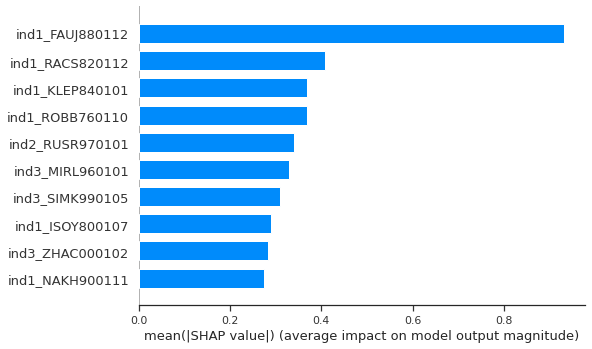

--------------------
VIRUS
class proportion=0.02; score=0.95


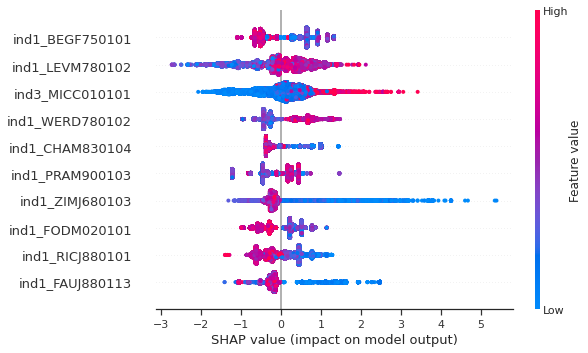

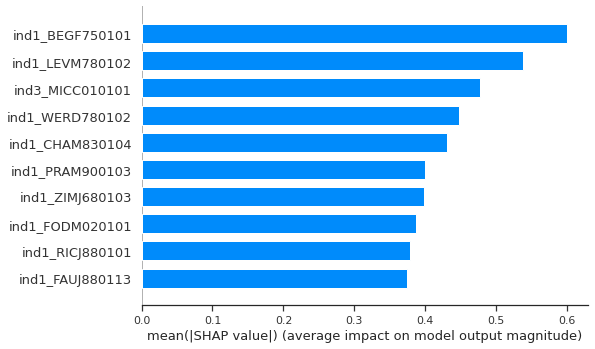

--------------------
SUGAR BINDING PROTEIN
class proportion=0.01; score=0.89


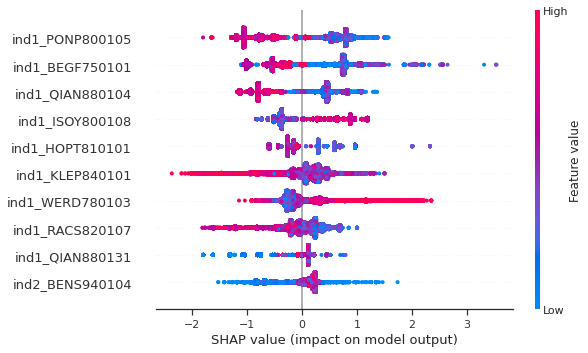

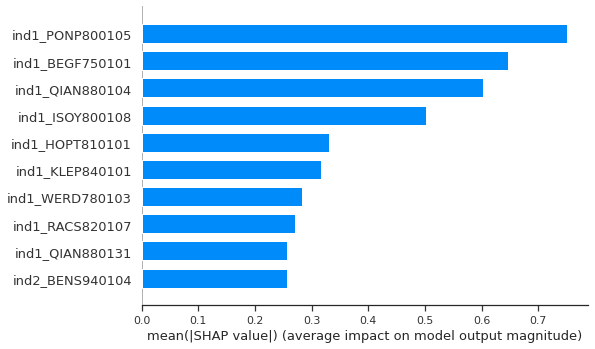

--------------------
HORMONE
class proportion=0.0; score=0.91


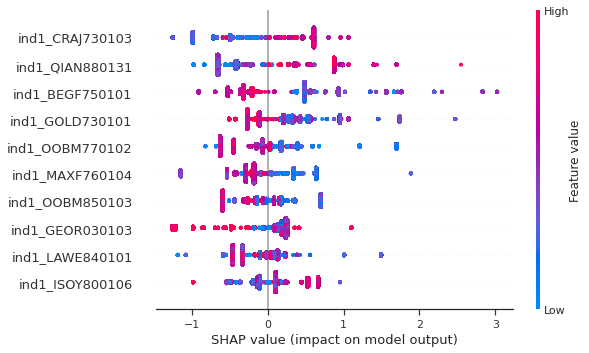

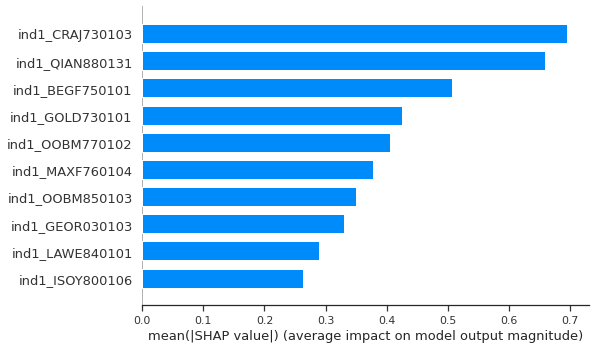

--------------------
TRANSCRIPTION
class proportion=0.03; score=0.78


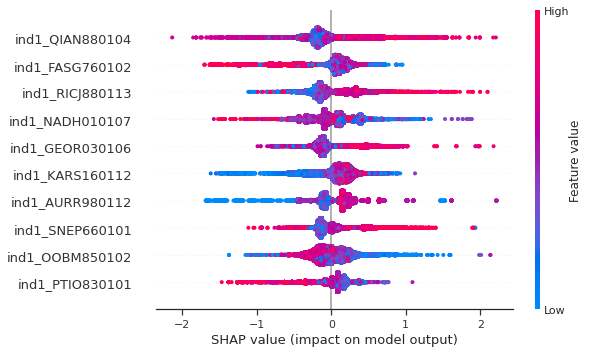

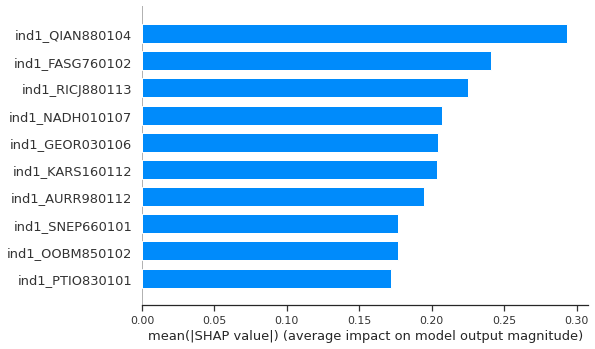

--------------------
MEMBRANE PROTEIN
class proportion=0.01; score=0.81


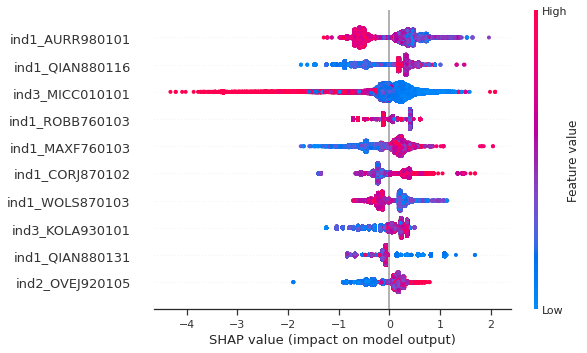

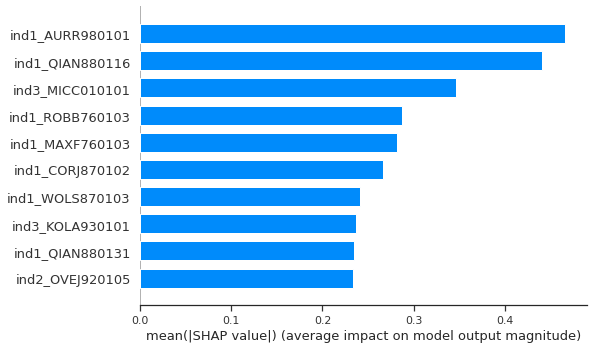

--------------------


In [0]:
valuable_features = visualization(classifiers, X)

## А не поглядеть ли нам на то, что это за фичи?

In [0]:
# чтобы по-быстрому получать описание того или иного индекса, соберем их описание
import urllib.request
pages = ['list_of_indices', 'list_of_matrices', 'list_of_potentials'] # aaind1, aaind2, aaind3
index2description = {} # собирать будем сюды

for p in pages:
    fp = urllib.request.urlopen("https://www.genome.jp/aaindex/AAindex/{}".format(p))
    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()
    slist = mystr.split('\n')[5:-1]

    for s in slist:
        key, *descr = s.split()
        index2description[key] = ' '.join(descr)

In [0]:
# Choose `n_best_features_to_view` beat features from each clf
n_best_features_to_view = 5
ten_best_fea_from_each = []
n_best_fea_from_each = []
value_scores = []
for cclass,df_fea in valuable_features:
    print(cclass)
    ten_best_fea_from_each.extend(list(df_fea.col_name))
    n_best_fea_from_each.extend(list(df_fea.head(n_best_features_to_view).col_name))
    
    for _,ser in df_fea[:n_best_features_to_view].iterrows():
        colname,val = ser 
        value_scores.append(val)
        print('{} ({:.2f}) - {}'.format(colname, val, index2description[colname[5:]]))
    print()

print(f'{len(ten_best_fea_from_each)} features, and {len(set(ten_best_fea_from_each))} is unique')
print(f'{len(n_best_fea_from_each)} features, and {len(set(n_best_fea_from_each))} is unique')

HYDROLASE
ind1_KARS160122 (0.25) - Weighted second smallest eigenvalue of the weighted Laplacian matrix (Karkbara-Knisley, 2016)
ind1_KOEP990102 (0.24) - Beta-sheet propensity derived from designed sequences (Koehl-Levitt, 1999)
ind3_KESO980102 (0.23) - Quasichemical energy in an average protein environment derived from interfacial regions of protein-protein complexes
ind1_MAXF760104 (0.23) - Normalized frequency of left-handed alpha-helix (Maxfield-Scheraga, 1976)
ind1_GARJ730101 (0.20) - Partition coefficient (Garel et al., 1973)

TRANSFERASE
ind1_RICJ880117 (0.33) - Relative preference value at C" (Richardson-Richardson, 1988)
ind1_FAUJ880111 (0.33) - Positive charge (Fauchere et al., 1988)
ind1_BEGF750101 (0.32) - Conformational parameter of inner helix (Beghin-Dirkx, 1975)
ind1_NISK800101 (0.23) - 8 A contact number (Nishikawa-Ooi, 1980)
ind1_QIAN880119 (0.23) - Weights for beta-sheet at the window position of -1 (Qian-Sejnowski, 1988)

OXIDOREDUCTASE
ind1_FASG760104 (0.52) - pK-N

Интерпретировать значимые индексы сложно, они непонятные, слишком физико-химические. 

Однако есть и простые:
- отрицательный заряд
- показатель преломления
- количество доноров водородных связей
- гидрофобность/гидрофильность
- температура плавления

Но, в целом, все сложно

## Проверим качество классификации на отборных значимых фичах (только 10 лучших для каждого класса белков)

In [0]:
def train_diminished(X, valuable_features,n_fea=10):

    classifiers = []

    for current_class,df_fea in valuable_features:
        print(current_class)

        X_diminished = X[df_fea.head(n_fea).col_name]
        y = (data['classification'] == current_class).astype(int)
        print('class proportion={:.2f}'.format(y.sum() / len(y)))
        
        X_train,X_test,y_train,y_test = train_test_split(X_diminished, y, test_size = 0.25, random_state = 1128)
        model = CatBoostClassifier(iterations=300,
                                    depth=6,
                                    learning_rate=1,
                                    loss_function='CrossEntropy',
                                    verbose=True, 
                                    eval_metric='Recall')
        # train the model
        model.fit(X_train, y_train, eval_set=(X_test, y_test), 
                  metric_period=150, early_stopping_rounds=50)
        
        # make the prediction using the resulting model
        preds = model.predict(X_test)

        score = roc_auc_score(y_test, preds)
        classifiers.append((current_class, model, score))
        print('score =', round(score, 3))
        print('-'*20)
        print()
    return classifiers

In [0]:
clfs = train_diminished(X, valuable_features)

HYDROLASE
class proportion=0.13
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 31.9ms	remaining: 9.54s


150:	learn: 0.6130874	test: 0.4815466	best: 0.4815466 (150)	total: 4.53s	remaining: 4.47s
299:	learn: 0.7835812	test: 0.5743409	best: 0.5750439 (296)	total: 8.83s	remaining: 0us

bestTest = 0.5750439367
bestIteration = 296

Shrink model to first 297 iterations.
score = 0.77
--------------------

TRANSFERASE
class proportion=0.11


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 33.8ms	remaining: 10.1s
150:	learn: 0.6434462	test: 0.4777011	best: 0.4777011 (150)	total: 5.01s	remaining: 4.95s
299:	learn: 0.8132548	test: 0.5678161	best: 0.5678161 (299)	total: 9.37s	remaining: 0us

bestTest = 0.567816092
bestIteration = 299

score = 0.771
--------------------

OXIDOREDUCTASE
class proportion=0.10


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 41.6ms	remaining: 12.4s
150:	learn: 0.7557517	test: 0.5859375	best: 0.5932617 (146)	total: 4.46s	remaining: 4.4s
299:	learn: 0.8997794	test: 0.6865234	best: 0.6865234 (299)	total: 8.86s	remaining: 0us

bestTest = 0.6865234375
bestIteration = 299

score = 0.833
--------------------

LYASE
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 40.9ms	remaining: 12.2s
150:	learn: 0.8194058	test: 0.5668966	best: 0.5668966 (150)	total: 4.43s	remaining: 4.37s
299:	learn: 0.9656453	test: 0.6648276	best: 0.6731034 (292)	total: 8.85s	remaining: 0us

bestTest = 0.6731034483
bestIteration = 292

Shrink model to first 293 iterations.
score = 0.834
--------------------

ISOMERASE
class proportion=0.02


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 36.7ms	remaining: 11s
150:	learn: 0.8444640	test: 0.5620438	best: 0.5669100 (148)	total: 4.4s	remaining: 4.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6326034063
bestIteration = 242

Shrink model to first 243 iterations.
score = 0.815
--------------------

LIGASE
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 49.7ms	remaining: 14.9s
150:	learn: 0.8485876	test: 0.5017544	best: 0.5017544 (148)	total: 4.44s	remaining: 4.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5543859649
bestIteration = 239

Shrink model to first 240 iterations.
score = 0.776
--------------------

FLUORESCENT PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 39.4ms	remaining: 11.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7213114754
bestIteration = 32

Shrink model to first 33 iterations.
score = 0.861
--------------------

BIOSYNTHETIC PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 34.5ms	remaining: 10.3s
150:	learn: 0.9550000	test: 0.6101695	best: 0.6440678 (118)	total: 4.32s	remaining: 4.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6440677966
bestIteration = 118

Shrink model to first 119 iterations.
score = 0.822
--------------------

VIRUS
class proportion=0.02


0:	learn: 0.3746006	test: 0.3985507	best: 0.3985507 (0)	total: 48.9ms	remaining: 14.6s
150:	learn: 0.9888179	test: 0.8719807	best: 0.8768116 (123)	total: 4.43s	remaining: 4.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8768115942
bestIteration = 123

Shrink model to first 124 iterations.
score = 0.938
--------------------

SUGAR BINDING PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 41.6ms	remaining: 12.4s
150:	learn: 0.9600639	test: 0.7300885	best: 0.7389381 (146)	total: 4.37s	remaining: 4.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7389380531
bestIteration = 146

Shrink model to first 147 iterations.
score = 0.869
--------------------

HORMONE
class proportion=0.00
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 31.7ms	remaining: 9.47s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8229166667
bestIteration = 36

Shrink model to first 37 iterations.
score = 0.911
--------------------

TRANSCRIPTION
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 39.2ms	remaining: 11.7s
150:	learn: 0.7387276	test: 0.4683544	best: 0.4792043 (143)	total: 4.35s	remaining: 4.3s
299:	learn: 0.8999382	test: 0.5352622	best: 0.5388788 (261)	total: 8.64s	remaining: 0us

bestTest = 0.5388788427
bestIteration = 261

Shrink model to first 262 iterations.
score = 0.766
--------------------

MEMBRANE PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 41.1ms	remaining: 12.3s
150:	learn: 0.8337104	test: 0.5589226	best: 0.5656566 (145)	total: 4.34s	remaining: 4.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5791245791
bestIteration = 177

Shrink model to first 178 iterations.
score = 0.789
--------------------



In [0]:
# how good are our classifiers?
for cclass,_,score in sorted(clfs, key=lambda x:x[-1]):
    print(cclass + ' '*(20-len(cclass)) + '\t', round(score, 3))

# cclass                 score
# TRANSCRIPTION       	 0.779
# LIGASE              	 0.788
# BIOSYNTHETIC PROTEIN	 0.805
# MEMBRANE PROTEIN    	 0.814
# HYDROLASE           	 0.827
# ISOMERASE           	 0.831
# TRANSFERASE         	 0.852
# LYASE               	 0.87
# OXIDOREDUCTASE      	 0.885
# SUGAR BINDING PROTEIN	 0.891
# FLUORESCENT PROTEIN 	 0.893
# HORMONE             	 0.911
# VIRUS               	 0.946

TRANSCRIPTION       	 0.766
HYDROLASE           	 0.77
TRANSFERASE         	 0.771
LIGASE              	 0.776
MEMBRANE PROTEIN    	 0.789
ISOMERASE           	 0.815
BIOSYNTHETIC PROTEIN	 0.822
OXIDOREDUCTASE      	 0.833
LYASE               	 0.834
FLUORESCENT PROTEIN 	 0.861
SUGAR BINDING PROTEIN	 0.869
HORMONE             	 0.911
VIRUS               	 0.938


Для каких-то классов качество почти не изменилось, но все-таки 10 фич недостаточно для того же качетсва

# Compare with **embeddings**

In [0]:
!pip install tape_proteins

In [16]:
import torch
from tape import ProteinBertModel, TAPETokenizer
from tape.datasets import pad_sequences

device = torch.device('cuda')
model = ProteinBertModel.from_pretrained('bert-base')
model.cuda()
tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

# Pfam Family: Hexapep, Clan: CL0536
sequence = 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ'
token_ids = tokenizer.encode(sequence)

def get_one_embedding(token_ids):
    """
    get TAPE Token and return embedding: 768 nums for each aa in seq
    
    на выходе вектор из усредненных по последовательности эмбеддингов
    """
    token_ids = torch.tensor([token_ids]).cuda()
    output = model(token_ids)
    sequence_output = output[0]
    # pooled_output = output[1]
    return sequence_output.mean(axis=1).detach().cpu().numpy()

sequence_output = get_one_embedding(token_ids)
sequence_output.shape
# NOTE: pooled_output is *not* trained for the transformer, do not use
# w/o fine-tuning. A better option for now is to simply take a mean of
# the sequence output

(1, 768)

In [0]:
# закодируем сиквенсы в удобоваримый формат для предобученной сетки 
# (просто определенное число для каждой аминокислоты)
enc_data = data.Sequence.apply(tokenizer.encode)

In [20]:
%%time
# посчитаем эмбеддинги
embs = np.concatenate(enc_data.apply(get_one_embedding)) # 7:25 - 9:00

CPU times: user 1h 10min 39s, sys: 18min 43s, total: 1h 29min 22s
Wall time: 1h 29min 24s


In [0]:
# np.save('/gdrive/My Drive/embs.npy', embs)

In [22]:
embs.shape

(83932, 768)

In [28]:
# затрейним новые леса
eclfs = train(embs)

HYDROLASE
class proportion=0.13


0:	learn: 0.0649613	test: 0.0629174	best: 0.0629174 (0)	total: 523ms	remaining: 2m 36s
50:	learn: 0.6715051	test: 0.5771529	best: 0.5771529 (48)	total: 20.6s	remaining: 1m 40s
100:	learn: 0.7806068	test: 0.6439367	best: 0.6453427 (98)	total: 39.7s	remaining: 1m 18s
150:	learn: 0.8449732	test: 0.6759227	best: 0.6783831 (148)	total: 58.9s	remaining: 58.1s
200:	learn: 0.8828079	test: 0.6956063	best: 0.6973638 (196)	total: 1m 17s	remaining: 38.4s
250:	learn: 0.9112433	test: 0.7072056	best: 0.7086116 (220)	total: 1m 37s	remaining: 19s
299:	learn: 0.9288519	test: 0.7254833	best: 0.7254833 (297)	total: 1m 56s	remaining: 0us

bestTest = 0.725483304
bestIteration = 297

Shrink model to first 298 iterations.
score = 0.849
--------------------

TRANSFERASE
class proportion=0.11


0:	learn: 0.0653903	test: 0.0634483	best: 0.0634483 (0)	total: 448ms	remaining: 2m 13s
50:	learn: 0.7073638	test: 0.6022989	best: 0.6022989 (49)	total: 20.4s	remaining: 1m 39s
100:	learn: 0.8237113	test: 0.6855172	best: 0.6855172 (100)	total: 39.8s	remaining: 1m 18s
150:	learn: 0.8868925	test: 0.7241379	best: 0.7241379 (150)	total: 59.3s	remaining: 58.5s
200:	learn: 0.9266568	test: 0.7379310	best: 0.7402299 (193)	total: 1m 18s	remaining: 38.7s
250:	learn: 0.9505155	test: 0.7590805	best: 0.7618391 (244)	total: 1m 37s	remaining: 19.1s
299:	learn: 0.9608247	test: 0.7659770	best: 0.7687356 (298)	total: 1m 56s	remaining: 0us

bestTest = 0.7687356322
bestIteration = 298

Shrink model to first 299 iterations.
score = 0.875
--------------------

OXIDOREDUCTASE
class proportion=0.10


0:	learn: 0.0924992	test: 0.0947266	best: 0.0947266 (0)	total: 468ms	remaining: 2m 20s
50:	learn: 0.8271352	test: 0.7373047	best: 0.7373047 (50)	total: 20.6s	remaining: 1m 40s
100:	learn: 0.9202647	test: 0.8085938	best: 0.8090820 (97)	total: 39.8s	remaining: 1m 18s
150:	learn: 0.9519382	test: 0.8217773	best: 0.8217773 (150)	total: 58.8s	remaining: 58s
200:	learn: 0.9728963	test: 0.8330078	best: 0.8334961 (189)	total: 1m 17s	remaining: 38.3s
250:	learn: 0.9799874	test: 0.8369141	best: 0.8398438 (218)	total: 1m 36s	remaining: 18.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.83984375
bestIteration = 218

Shrink model to first 219 iterations.
score = 0.914
--------------------

LYASE
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 443ms	remaining: 2m 12s
50:	learn: 0.7906221	test: 0.6413793	best: 0.6413793 (50)	total: 19.7s	remaining: 1m 35s
100:	learn: 0.9168988	test: 0.7379310	best: 0.7379310 (99)	total: 38.3s	remaining: 1m 15s
150:	learn: 0.9740019	test: 0.7586207	best: 0.7586207 (150)	total: 57s	remaining: 56.2s
200:	learn: 0.9823584	test: 0.7737931	best: 0.7848276 (187)	total: 1m 15s	remaining: 37.3s
250:	learn: 0.9805014	test: 0.7793103	best: 0.7903448 (241)	total: 1m 34s	remaining: 18.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7903448276
bestIteration = 241

Shrink model to first 242 iterations.
score = 0.893
--------------------

ISOMERASE
class proportion=0.02


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 433ms	remaining: 2m 9s
50:	learn: 0.7653779	test: 0.5790754	best: 0.5912409 (49)	total: 19s	remaining: 1m 32s
100:	learn: 0.9156415	test: 0.6836983	best: 0.6861314 (95)	total: 37s	remaining: 1m 12s
150:	learn: 0.9569420	test: 0.6812652	best: 0.6982968 (129)	total: 55s	remaining: 54.3s
200:	learn: 0.9639719	test: 0.6861314	best: 0.7007299 (152)	total: 1m 13s	remaining: 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.700729927
bestIteration = 152

Shrink model to first 153 iterations.
score = 0.85
--------------------

LIGASE
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 434ms	remaining: 2m 9s
50:	learn: 0.7355932	test: 0.4912281	best: 0.4912281 (50)	total: 18.6s	remaining: 1m 30s
100:	learn: 0.8915254	test: 0.5508772	best: 0.5614035 (94)	total: 36.6s	remaining: 1m 12s
150:	learn: 0.9525424	test: 0.5929825	best: 0.6035088 (132)	total: 54.7s	remaining: 54s
200:	learn: 0.9593220	test: 0.6140351	best: 0.6175439 (182)	total: 1m 12s	remaining: 35.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6175438596
bestIteration = 182

Shrink model to first 183 iterations.
score = 0.808
--------------------

FLUORESCENT PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 443ms	remaining: 2m 12s
50:	learn: 0.9948454	test: 0.8196721	best: 0.8196721 (17)	total: 18.6s	remaining: 1m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8196721311
bestIteration = 17

Shrink model to first 18 iterations.
score = 0.91
--------------------

BIOSYNTHETIC PROTEIN
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 450ms	remaining: 2m 14s
50:	learn: 0.8600000	test: 0.5423729	best: 0.5423729 (48)	total: 17.7s	remaining: 1m 26s
100:	learn: 0.9450000	test: 0.5762712	best: 0.5762712 (65)	total: 35.2s	remaining: 1m 9s
150:	learn: 0.9500000	test: 0.5932203	best: 0.5932203 (104)	total: 52.7s	remaining: 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.593220339
bestIteration = 104

Shrink model to first 105 iterations.
score = 0.797
--------------------

VIRUS
class proportion=0.02


0:	learn: 0.3698083	test: 0.3888889	best: 0.3888889 (0)	total: 447ms	remaining: 2m 13s
50:	learn: 0.9704473	test: 0.8671498	best: 0.8695652 (49)	total: 18.7s	remaining: 1m 31s
100:	learn: 0.9912141	test: 0.8913043	best: 0.8913043 (86)	total: 36.8s	remaining: 1m 12s
150:	learn: 0.9904153	test: 0.8937198	best: 0.8961353 (117)	total: 54.7s	remaining: 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8961352657
bestIteration = 117

Shrink model to first 118 iterations.
score = 0.947
--------------------

SUGAR BINDING PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 436ms	remaining: 2m 10s
50:	learn: 0.9249201	test: 0.7699115	best: 0.7699115 (48)	total: 18.5s	remaining: 1m 30s
100:	learn: 0.9664537	test: 0.7920354	best: 0.7920354 (67)	total: 36s	remaining: 1m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7920353982
bestIteration = 67

Shrink model to first 68 iterations.
score = 0.895
--------------------

HORMONE
class proportion=0.00


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 446ms	remaining: 2m 13s
50:	learn: 0.9557196	test: 0.8125000	best: 0.8125000 (29)	total: 17.5s	remaining: 1m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8125
bestIteration = 29

Shrink model to first 30 iterations.
score = 0.906
--------------------

TRANSCRIPTION
class proportion=0.03


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 428ms	remaining: 2m 7s
50:	learn: 0.7059914	test: 0.4936709	best: 0.4936709 (47)	total: 19.1s	remaining: 1m 33s
100:	learn: 0.8437307	test: 0.5424955	best: 0.5461121 (91)	total: 37.3s	remaining: 1m 13s
150:	learn: 0.9073502	test: 0.5768535	best: 0.5804702 (148)	total: 55s	remaining: 54.3s
200:	learn: 0.9264978	test: 0.5786618	best: 0.5840868 (168)	total: 1m 13s	remaining: 36s
250:	learn: 0.9289685	test: 0.5840868	best: 0.5931284 (214)	total: 1m 31s	remaining: 17.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5931283906
bestIteration = 214

Shrink model to first 215 iterations.
score = 0.794
--------------------

MEMBRANE PROTEIN
class proportion=0.01


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 454ms	remaining: 2m 15s
50:	learn: 0.7533937	test: 0.5690236	best: 0.5690236 (48)	total: 18.2s	remaining: 1m 29s
100:	learn: 0.8721719	test: 0.6195286	best: 0.6296296 (88)	total: 35.8s	remaining: 1m 10s
150:	learn: 0.9174208	test: 0.6363636	best: 0.6464646 (135)	total: 53.9s	remaining: 53.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6464646465
bestIteration = 135

Shrink model to first 136 iterations.
score = 0.822
--------------------



Логи обучения говорят, что на этих эмбеддингах знатное переобучение осуществляется, хех. Вроде бы даже больше, чем на индексах

In [30]:
# how good are our classifiers?
emb_scores = {}
for cclass,_,score in sorted(eclfs, key=lambda x:x[-1]):
    print(cclass + ' '*(20-len(cclass)) + '\t', round(score, 3))
    emb_scores[cclass] = round(score, 3)

# cclass                 score

TRANSCRIPTION       	 0.794
BIOSYNTHETIC PROTEIN	 0.797
LIGASE              	 0.808
MEMBRANE PROTEIN    	 0.822
HYDROLASE           	 0.849
ISOMERASE           	 0.85
TRANSFERASE         	 0.875
LYASE               	 0.893
SUGAR BINDING PROTEIN	 0.895
HORMONE             	 0.906
FLUORESCENT PROTEIN 	 0.91
OXIDOREDUCTASE      	 0.914
VIRUS               	 0.947


In [0]:
# запускал тетрадку по частям, и скоры были только в аутпутах
# соберем их для наглядного сравнения

full_ind_scores = {'TRANSCRIPTION': 0.779,
                  'LIGASE': 0.788,
                  'BIOSYNTHETIC PROTEIN': 0.805,
                  'MEMBRANE PROTEIN': 0.814,
                  'HYDROLASE': 0.827,
                  'ISOMERASE': 0.831,
                  'TRANSFERASE': 0.852,
                  'LYASE': 0.87,
                  'OXIDOREDUCTASE': 0.885,
                  'SUGAR BINDING PROTEIN': 0.891,
                  'FLUORESCENT PROTEIN': 0.893,
                  'HORMONE': 0.911,
                  'VIRUS': 0.946}

best_10_inds_scores = {'TRANSCRIPTION': 0.766,
                      'HYDROLASE': 0.77,
                      'TRANSFERASE': 0.771,
                      'LIGASE': 0.776,
                      'MEMBRANE PROTEIN': 0.789,
                      'ISOMERASE': 0.815,
                      'BIOSYNTHETIC PROTEIN': 0.822,
                      'OXIDOREDUCTASE': 0.833,
                      'LYASE': 0.834,
                      'FLUORESCENT PROTEIN': 0.861,
                      'SUGAR BINDING PROTEIN': 0.869,
                      'HORMONE': 0.911,
                      'VIRUS': 0.938}

emb_scores = {'BIOSYNTHETIC PROTEIN': 0.797,
              'FLUORESCENT PROTEIN': 0.91,
              'HORMONE': 0.906,
              'HYDROLASE': 0.849,
              'ISOMERASE': 0.85,
              'LIGASE': 0.808,
              'LYASE': 0.893,
              'MEMBRANE PROTEIN': 0.822,
              'OXIDOREDUCTASE': 0.914,
              'SUGAR BINDING PROTEIN': 0.895,
              'TRANSCRIPTION': 0.794,
              'TRANSFERASE': 0.875,
              'VIRUS': 0.947}

unite_scores = pd.DataFrame([full_ind_scores, 
                             best_10_inds_scores, 
                             emb_scores], index=['full_ind', 'best_ind', 'emb']).T

In [54]:
# number of max element in columns
unite_scores.values.argmax(axis=1)

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2])

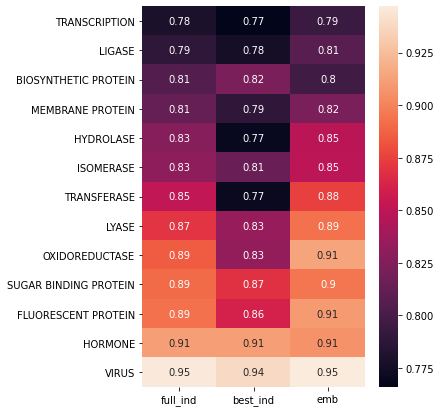

In [52]:
plt.figure(figsize=(5,7))
sns.heatmap(unite_scores, annot=True, )
plt.show()

Как оказалось, *бертовские эмбеддинги* дали **результат лучше** почти в любом случае. И это несмотря на то, что они на самом деле считались для каждой аминокислоты, как и индексы, и были усреднены для каждой последовательности.

Это значит, что индексы - хорошо, а нейросетки лучше

Что еще можно сделать?
- нормально обучить на текущих фичах с учетом структуры белков (CNN | RNN)
- взять весь датасет
- сравнить с отдельной RNN, которая делает many-to-one
- подправить датасет; изучить классы и прочее; там есть большие пересечения по смыслу